In [1]:
# %conda env update -f env.yml

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda


Installing pip dependencies: / Ran pip subprocess with arguments:
['/home/studio-lab-user/.conda/envs/hackathon_data/bin/python', '-m', 'pip', 'install', '-U', '-r', '/home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/notebooks/condaenv.kbx1ap0z.requirements.txt']
Pip subprocess output:

done
#
# To activate this environment, use
#
#     $ conda activate /home/studio-lab-user/.conda/envs/hackathon_data
#
# To deactivate an active environment, use
#
#     $ conda deactivate


Note: you may need to restart the kernel to use updated packages.


[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/dataset_preparation/2_PredictionDataCreation.ipynb)

In [2]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import os
from pathlib import Path
from random import sample
import shutil
import subprocess

import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import s3fs
from shapely.geometry import box
import rasterio
from rasterio.errors import RasterioIOError

In [3]:
from src.constants import FIRMS_API_KEY, DEFAULT_PARAMS
from src.data_sources import (cluster_fires, 
                              create_chip_bounds, 
                              ndvi_from_topleft, 
                              landcover_from_topleft, 
                              atmospheric_from_topleft, 
                              fires_from_topleft,
                              elevation_from_topleft)

In [4]:
if not FIRMS_API_KEY:
    raise ValueError('FIRMS_API_KEY empty, please ensure your environment variable set')

# Input parameters

In [5]:
output_fp = '/home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/predict_test'
output_s3 = os.environ['AWS_S3_BUCKET'] + '/predict_test'

# North America
bbox= [-168.7,24.8,-51.8,74.2]

# dates to search for fires
begin_date = datetime(2021,12,1)
end_date   = datetime(2021,12,15)

In [6]:
fs = s3fs.S3FileSystem(key=os.environ['AWS_ACCESS_KEY_ID'], secret=os.environ['AWS_SECRET_ACCESS_KEY'])

# Load fire data

In [7]:
def load_fires(begin_date, end_date, bbox, day_range=10):
    """
    Given input parameters, search NASA firms API for fires and return GeoDataFrame of fire points
    :param begin_date: datetime
    :param end_date: datetime
    :param bbox: list of floats; left, bottom, right, top
    :param day_range: int for the number of days to search API for
    :return: gpd.GeoDataFrame of fire points
    """
    if day_range > 10:
        # firms api allows max of 10 day range see https://firms.modaps.eosdis.nasa.gov/api/area/
        raise ValueError('"day_range" must be less than or equal to 10')

    start_dates = (pd.date_range(start=begin_date, end=end_date, freq=f"{day_range}D") + pd.Timedelta(f'{day_range}d')).to_pydatetime().tolist()
    if len(start_dates) == 0:
        raise ValueError('No dates to search for, check "begin_date" and "end_date" are formated correctly')
        
    # get min date of the VIIRS_SNPP_NRT so that we can decide based on the date range which FIRMS product(s) we need
    viirs_nrt = pd.read_csv(f'https://firms.modaps.eosdis.nasa.gov/api/data_availability/csv/{FIRMS_API_KEY}/VIIRS_SNPP_NRT')
    viirs_nrt_start = datetime.strptime(viirs_nrt.iloc[0].min_date, '%Y-%m-%d')

    df_fires = pd.DataFrame()
    for start_date in start_dates:
        mapkey_status = requests.get(f'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY={FIRMS_API_KEY}')
        if mapkey_status.json()['current_transactions'] > 460:
            # TODO: tenacity retry wait_exponential:
            raise ValueError('Not enough free transactions left with FIRMS API for given key')

        # split requests by date for VIIRS_SNPP_SP/VIIRS_SNPP_NRT
        if start_date > viirs_nrt_start:
            nrt_request_url = f'https://firms.modaps.eosdis.nasa.gov/api/area/csv/{FIRMS_API_KEY}/VIIRS_SNPP_NRT/{",".join([str(i) for i in bbox])}/{day_range}/{start_date.strftime("%Y-%m-%d")}'
            df_fires=df_fires.append(pd.read_csv(nrt_request_url),ignore_index=True)
        if (start_date - timedelta(days=day_range)) < viirs_nrt_start:
            sp_request_url = f'https://firms.modaps.eosdis.nasa.gov/api/area/csv/{FIRMS_API_KEY}/VIIRS_SNPP_SP/{",".join([str(i) for i in bbox])}/{day_range}/{start_date.strftime("%Y-%m-%d")}'
            df_fires=df_fires.append(pd.read_csv(sp_request_url),ignore_index=True)

    # drop fires after end_date
    df_fires = df_fires[((df_fires['acq_date'].astype('datetime64[ns]') <= end_date) & (df_fires['acq_date'].astype('datetime64[ns]') >= begin_date))]
    gdf_fires = gpd.GeoDataFrame(df_fires, geometry=gpd.points_from_xy(df_fires.longitude, df_fires.latitude), crs='EPSG:4326')
    return gdf_fires

In [8]:
gdf_fires = load_fires(begin_date, end_date, bbox)
gdf_fires

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry
0,41.681828,-87.419044,303.93,0.52,0.67,2021-12-02,642,N,VIIRS,n,1,276.68,1.72,N,3,POINT (-87.41904 41.68183)
1,36.356743,-76.805153,305.49,0.42,0.38,2021-12-02,642,N,VIIRS,n,1,274.95,1.35,N,2,POINT (-76.80515 36.35674)
2,37.380699,-83.431396,306.84,0.59,0.53,2021-12-02,642,N,VIIRS,n,1,278.60,2.53,N,0,POINT (-83.43140 37.38070)
3,37.385071,-83.423508,306.01,0.59,0.53,2021-12-02,642,N,VIIRS,n,1,279.08,1.81,N,0,POINT (-83.42351 37.38507)
4,38.999557,-87.725594,300.07,0.52,0.67,2021-12-02,642,N,VIIRS,n,1,282.15,1.40,N,2,POINT (-87.72559 38.99956)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10921,45.576324,-118.592232,331.42,0.39,0.36,2021-12-15,2048,N,VIIRS,n,1,274.07,12.19,D,0,POINT (-118.59223 45.57632)
10922,46.075047,-118.900040,328.43,0.39,0.36,2021-12-15,2048,N,VIIRS,n,1,280.82,2.87,D,3,POINT (-118.90004 46.07505)
10923,46.111504,-118.996841,334.96,0.39,0.36,2021-12-15,2048,N,VIIRS,n,1,278.03,3.07,D,0,POINT (-118.99684 46.11150)
10924,45.577744,-118.582275,327.49,0.39,0.36,2021-12-15,2048,N,VIIRS,n,1,274.66,15.82,D,0,POINT (-118.58227 45.57774)


In [9]:
# create clusters
print('Clustering fires')
df_fire_clustered = cluster_fires(gdf_fires)

# create chip bounds
print('Creating chip bounds')
Path(output_fp).mkdir(parents=True, exist_ok=True)
manifest = create_chip_bounds(df_fire_clustered)
manifest

Clustering fires
Creating chip bounds


,idx,left,bottom,right,top,epsg,date
0,0,499500.0,3767500.0,531500.0,3799500.0,32612,2021-12-02
1,1,389500.0,5996500.0,421500.0,6028500.0,32611,2021-12-02
2,2,613500.0,4814000.0,645500.0,4846000.0,32610,2021-12-04
3,3,521500.0,3431000.0,553500.0,3463000.0,32615,2021-12-05
4,4,678000.0,4268000.0,709500.0,4300000.0,32612,2021-12-05
5,5,406500.0,3929000.0,438500.0,3961000.0,32614,2021-12-10
6,6,738000.0,3933500.0,770000.0,3965500.0,32613,2021-12-15
7,7,274000.0,3923000.0,306000.0,3955000.0,32614,2021-12-15
8,8,247500.0,4047500.0,279500.0,4079500.0,32614,2021-12-15
9,9,546500.0,4059500.0,578500.0,4091500.0,32614,2021-12-15


# Process Chips

In [10]:
def process_chip(chip, fs, output_fp, output_s3, fires, cog_footprints, training=True):
    """
    Given a chips metadata, load all of the training data and write numpy files, finally upload results to S3
    :param chip: records.csv chip to process data for
    :param fs: s3fs.S3FileSystem
    :param output_fp: local directory to write data to
    :param output_s3: local directory to write data to
    :param fires: gpd.GeoDataFrame or path to vector file containing fire point data
    :param cog_footprints: gpd.GeoDataFrame of the dem footprints
    :param training: bool, if true then will load/write next days fires
    """
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    
    if os.path.exists(output_fp + f'/{chip_idx}'):
        return
    
    # check not already on s3
    if len(fs.ls(f'{output_s3}/{chip_idx}')) != 0:
        return
    
    print(f'Processing chip: {chip_idx}')
    
    # create output dir if it doesnt already exist
    output_dir = Path(output_fp).joinpath(str(chip_idx))
    output_dir.mkdir(parents=True, exist_ok=True)

    # load modis
    try:
        ndvi = ndvi_from_topleft([top, left], epsg, chip_date)
        np.save(output_dir.joinpath('ndvi.npy'), ndvi)
    except RasterioIOError:
        # modis missing from bucket
        shutil.rmtree(output_dir)
        return
    
    # save bbox to geojson
    bounds_utm = rasterio.coords.BoundingBox(left=left, right=right, bottom=bottom, top=top)
    gpd.GeoSeries([box(*bounds_utm)]).set_crs(epsg).to_file(output_dir.joinpath('bbox.geojson'))
    
    # load fires
    todays_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires)
    np.save(output_dir.joinpath(f'todays_fires.npy'), todays_fires.bool)
    np.save(output_dir.joinpath(f'todays_frp.npy'), todays_fires.frp)
    
    # load tomorrows fires if training
    if training:
        tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
        tomorrows_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires)
        np.save(output_dir.joinpath(f'tomorrows_fires.npy'), tomorrows_fires.bool)
        np.save(output_dir.joinpath(f'tomorrows_frp.npy'), tomorrows_fires.frp)
    
    # load dem
    dem = elevation_from_topleft([top, left], epsg, cog_footprints)
    np.save(output_dir.joinpath('elevation.npy'), dem)
    
    # load landcover
    landcover = landcover_from_topleft([top, left], epsg)
    np.save(output_dir.joinpath('landcover.npy'), landcover)
    
    # load atmospheric
    atmos = atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS)
    for var in list(atmos.data_vars):
        data_arr = getattr(atmos, var).values[0]
        np.save(output_dir.joinpath(f'{var}.npy'), data_arr)
    
    fs.upload(str(output_dir), 
              f'{output_s3}/{chip_idx}/',
             recursive=True)
    shutil.rmtree(output_dir)

In [11]:
chips = list(manifest.T.to_dict().values())
print(f'Chips total = {len(chips)}')

Chips total = 10


In [12]:
# query s3 to see which chips already processed and remove from list
processed_chips = fs.ls(output_s3)
processed_ids = [int(x.split('/')[-1]) for x in processed_chips if x.split('/')[-1].isdigit()]
print(f'Processed = {len(processed_ids)}')
to_process = [x for x in chips if x['idx'] not in processed_ids]
print(f'To process = {len(to_process)}')

Processed = 0
To process = 10


In [16]:
%%time

os.environ['AWS_NO_SIGN_REQUEST'] = 'True'
cog_footprints = gpd.GeoDataFrame.from_file('s3://copernicus-dem-30m/grid.zip')

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    future_work = [
        executor.submit(process_chip, chip, fs, output_fp, output_s3, gdf_fires, cog_footprints, training=False) for chip in to_process
    ]

Processing chip: 3
Processing chip: 1
Processing chip: 0
Processing chip: 2
Processing chip: 4
Processing chip: 5
Processing chip: 6
Processing chip: 7
Processing chip: 8
Processing chip: 9
CPU times: user 17.5 s, sys: 4.51 s, total: 22 s
Wall time: 40.1 s


# Explore some of the processed chips

0


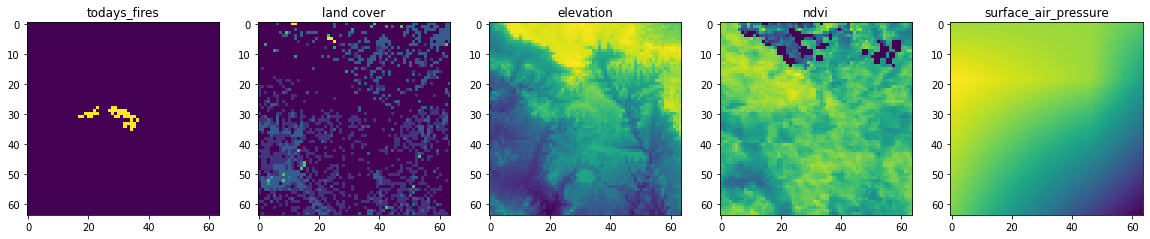

1
2


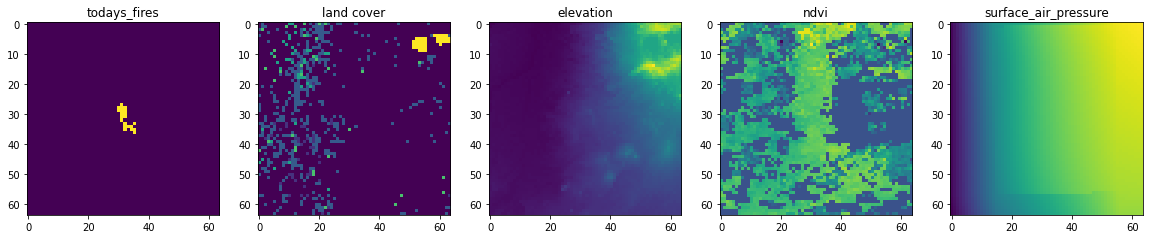

In [17]:
import matplotlib.pyplot as plt

for chip in [x for x in fs.ls(output_s3) if x.split('/')[-1].isdigit()]:
    print(chip.split('/')[-1])
    
    try:
        tf = np.load(fs.open(chip + '/todays_fires.npy'))
    except FileNotFoundError:
        continue
        
    fig, (ax1, ax3, ax4, ax5, ax6) = plt.subplots(1, 5, figsize=(20,20))

    im = ax1.imshow(tf)
    ax1.title.set_text('todays_fires')
    
    lc = np.load(fs.open(chip + '/landcover.npy'))
    im = ax3.imshow(lc)
    ax3.title.set_text('land cover')

    el = np.load(fs.open(chip + '/elevation.npy'))
    im = ax4.imshow(el)
    ax4.title.set_text('elevation')
    
    nd = np.load(fs.open(chip + '/ndvi.npy'))
    im = ax5.imshow(nd)
    ax5.title.set_text('ndvi')
    
    sa = np.load(fs.open(chip + '/surface_air_pressure.npy'))
    im = ax6.imshow(sa)
    ax6.title.set_text('surface_air_pressure')
    
    plt.show()